**bold text**# Prediction of Employement Rate from health data
This project consists of acquiring data from "Census.gov" via API and combine it with an existing Excel sheet dataset that consists of health related variables. The data is for all the counties in US. 

In [ ]:
# Importing dependies

import numpy as np
import pandas as pd
import requests
import json
import warnings
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt 
from math import sqrt
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error


### Data Acquisition and structructing

#### Requesting data from census.gov via API

In [ ]:
# ACS 5 years Employement data for year 2015
response_15 = requests.get('https://api.census.gov/data/2015/acs/acs5/profile?get=GEO_ID,NAME,DP03_0004E&for=county:*&key=a4bbe20d334ab33a7cc19e40ff3b30612c25d447')

json_data15 = response_15.json()

data_columns15 = json_data15[0]
data_array15 = json_data15[1:]
data_columns15[2]="Employement_15"
df15 = pd.DataFrame(data_array15,columns=data_columns15)

df15 = df15.iloc[:,:-2]
df15.sort_values(by=['GEO_ID'],inplace=True)
print(df15)


              GEO_ID                              NAME Employement_15
2135  0500000US01001           Autauga County, Alabama          23986
2579  0500000US01003           Baldwin County, Alabama          85953
2126  0500000US01005           Barbour County, Alabama           8597
2127  0500000US01007              Bibb County, Alabama           8294
2133  0500000US01009            Blount County, Alabama          22189
...              ...                               ...            ...
932   0500000US72145  Vega Baja Municipio, Puerto Rico          13660
861   0500000US72147    Vieques Municipio, Puerto Rico           2860
23    0500000US72149   Villalba Municipio, Puerto Rico           6795
862   0500000US72151    Yabucoa Municipio, Puerto Rico           8083
20    0500000US72153      Yauco Municipio, Puerto Rico           8923

[3220 rows x 3 columns]


In [ ]:
# ACS 5 years Employement data for year 2020
response_20 = requests.get('https://api.census.gov/data/2020/acs/acs5/profile?get=GEO_ID,NAME,DP03_0004E&for=county:*&key=a4bbe20d334ab33a7cc19e40ff3b30612c25d447')
json_data20 = response_20.json()

data_columns20 = json_data20[0]
data_array20 = json_data20[1:]
data_columns20[2]="Employement_20"
df20 = pd.DataFrame(data_array20,columns=data_columns20)

df20 = df20.iloc[:,:-2]
df20.sort_values(by=['GEO_ID'],inplace=True)
print(df20)


              GEO_ID                              NAME Employement_20
0     0500000US01001           Autauga County, Alabama          24580
1     0500000US01003           Baldwin County, Alabama          98768
2     0500000US01005           Barbour County, Alabama           8707
3     0500000US01007              Bibb County, Alabama           8303
4     0500000US01009            Blount County, Alabama          22836
...              ...                               ...            ...
1308  0500000US72145  Vega Baja Municipio, Puerto Rico          15013
1309  0500000US72147    Vieques Municipio, Puerto Rico           2053
1310  0500000US72149   Villalba Municipio, Puerto Rico           6506
2274  0500000US72151    Yabucoa Municipio, Puerto Rico           8644
1311  0500000US72153      Yauco Municipio, Puerto Rico           8856

[3221 rows x 3 columns]


### Merging Data
Merge data from 2015 and 2020 and calculate the growth rate of employement.

In [ ]:
# Merging based on 'GEO_ID'
df_Census = pd.merge(df15, df20, on='GEO_ID')

# Converting into numerical form for mathematical calculation
df_Census['Employement_20']= df_Census['Employement_20'].astype(float)
df_Census['Employement_15']= df_Census['Employement_15'].astype(float)

# The Employement Growth Rate calculation
df_Census['employment_growth_rates'] = ((df_Census.Employement_20/df_Census.Employement_15)**0.2) - 1

# Generating a new column "FIPS" to merge data from health and social dataset
df_Census['FIPS'] = df_Census['GEO_ID'].str[-5:]
df_Census['FIPS']= df_Census['FIPS'].astype(int)

# Dropping the columns that are not required for further analysis
df_Census = df_Census.drop(['GEO_ID', 'NAME_x', 'NAME_y', 'Employement_15', 'Employement_20'], axis=1)

# Switching Columns to make FIPS first Column
df_Census = df_Census.iloc[:, [1,0]]
print(df_Census)

       FIPS  employment_growth_rates
0      1001                 0.004905
1      1003                 0.028184
2      1005                 0.002546
3      1007                 0.000217
4      1009                 0.005765
...     ...                      ...
3214  72145                 0.019068
3215  72147                -0.064154
3216  72149                -0.008655
3217  72151                 0.013511
3218  72153                -0.001506

[3219 rows x 2 columns]


### Loading Data
Loading data from Excel Sheet

In [ ]:
# Acquring health data from the Excel sheet
df_health = pd.read_excel('/content/sample_data/health_social_data.xlsx')

df_health.head(5)

,FIPS,State,County,Deaths,Years of Potential Life Lost Rate,% Fair or Poor Health,Average Number of Physically Unhealthy Days,Average Number of Mentally Unhealthy Days,% Low Birthweight,% Smokers,...,% 65 and over,% Black,% American Indian & Alaska Native,% Asian,% Native Hawaiian/Other Pacific Islander,% Hispanic,% Non-Hispanic White,% Not Proficient in English,% Female,% Rural
0,1000,Alabama,NaN,81791.0,9942.794666,22.028703,4.918052,4.939753,10.254871,20.927353,...,16.917263,26.497733,0.703271,1.496909,0.106529,4.443264,65.413428,1.061048,51.633032,40.963183
1,1001,Alabama,Autauga,791.0,8128.591190,20.882987,4.743889,4.654031,8.619529,18.081557,...,15.562670,19.343177,0.480207,1.224798,0.111509,2.965774,74.308016,0.820225,51.448715,42.002162
2,1003,Alabama,Baldwin,2967.0,7354.122530,17.509134,4.224519,4.304056,8.345003,17.489033,...,20.443350,8.783976,0.772399,1.150343,0.066966,4.646779,83.111337,0.543517,51.538377,42.279099
3,1005,Alabama,Barbour,472.0,10253.573403,29.591802,5.430279,5.185594,11.474559,21.999985,...,19.420441,48.032635,0.659137,0.454162,0.184880,4.276355,45.641252,1.631683,47.216752,67.789635
4,1007,Alabama,Bibb,471.0,11977.539484,19.439724,4.591482,4.551699,10.308710,19.114200,...,16.473214,21.120536,0.437500,0.236607,0.116071,2.625000,74.589286,0.268210,46.781250,68.352607


In [ ]:
# Appending "Employement Growth Rate" to Health data USING "FIPS" as an Anchor

Run_data = pd.merge(df_health, df_Census, on='FIPS')

### Exploratory Data Analysis (EAD)
This process clean, bring clarity, and prepare the data for better prediction.

In [ ]:
# Converting Ratios (data present in the form of N:1) to numeric

Run_data['Other Primary Care Provider Ratio'] = Run_data['Other Primary Care Provider Ratio'].str[:-2]
Run_data['Other Primary Care Provider Ratio'] = Run_data['Other Primary Care Provider Ratio'].astype(float)
Run_data['Primary Care Physicians Ratio'] = Run_data['Primary Care Physicians Ratio'].str[:-2]
Run_data['Primary Care Physicians Ratio'] = Run_data['Primary Care Physicians Ratio'].astype(float)
Run_data['Dentist Ratio'] = Run_data['Dentist Ratio'].str[:-2]
Run_data['Dentist Ratio'] = Run_data['Dentist Ratio'].astype(float)
Run_data['Mental Health Provider Ratio'] = Run_data['Mental Health Provider Ratio'].str[:-2]
Run_data['Mental Health Provider Ratio'] = Run_data['Mental Health Provider Ratio'].astype(float)

# Converting binary data to numeric 

Run_data['Presence of Water Violation'] = Run_data['Presence of Water Violation'].map({"Yes":1, "No":0})

print(Run_data)

       FIPS    State      County  Deaths  Years of Potential Life Lost Rate  \
0      1001  Alabama     Autauga   791.0                        8128.591190   
1      1003  Alabama     Baldwin  2967.0                        7354.122530   
2      1005  Alabama     Barbour   472.0                       10253.573403   
3      1007  Alabama        Bibb   471.0                       11977.539484   
4      1009  Alabama      Blount  1085.0                       11335.071134   
...     ...      ...         ...     ...                                ...   
3136  56037  Wyoming  Sweetwater   532.0                        7831.827655   
3137  56039  Wyoming       Teton   109.0                        2730.603992   
3138  56041  Wyoming       Uinta   256.0                        7330.683549   
3139  56043  Wyoming    Washakie   110.0                        6586.049959   
3140  56045  Wyoming      Weston    89.0                        5388.706947   

      % Fair or Poor Health  Average Number of Phys

In [ ]:
Run_data.shape

(3141, 88)

In [ ]:
# Observing Basic Statistics
Run_data.describe()

,FIPS,Deaths,Years of Potential Life Lost Rate,% Fair or Poor Health,Average Number of Physically Unhealthy Days,Average Number of Mentally Unhealthy Days,% Low Birthweight,% Smokers,% Adults with Obesity,Food Environment Index,...,% Black,% American Indian & Alaska Native,% Asian,% Native Hawaiian/Other Pacific Islander,% Hispanic,% Non-Hispanic White,% Not Proficient in English,% Female,% Rural,employment_growth_rates
count,3141.000000,2848.000000,2848.000000,3141.000000,3141.000000,3141.000000,3034.000000,3141.000000,3141.000000,3122.000000,...,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000,3141.000000,3134.000000,3141.000000
mean,30392.602674,1335.188202,8583.392354,17.937830,3.990683,4.167679,8.141865,17.469601,32.856734,7.451441,...,8.995807,2.350262,1.567857,0.141343,9.654334,75.994720,1.701498,49.886107,58.568780,0.005426
std,15156.613190,3349.931806,2605.059554,4.740132,0.704800,0.602526,2.040026,3.610411,5.452671,1.145550,...,14.300474,7.726958,2.952403,0.967975,13.838789,20.196686,2.786360,2.283170,31.478671,0.019040
min,1001.000000,32.000000,2730.603992,8.120645,2.449054,2.532818,2.891156,5.908719,12.400000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.610451,2.691288,0.000000,26.835097,0.000000,-0.102001
25%,18179.000000,226.000000,6792.733094,14.321542,3.471774,3.749043,6.771241,14.940194,29.200000,6.900000,...,0.708630,0.384306,0.465678,0.031905,2.400223,64.305252,0.280183,49.411693,33.215524,-0.003935
50%,29177.000000,476.500000,8313.747213,17.220289,3.936398,4.172955,7.804878,16.954345,33.100000,7.650000,...,2.228226,0.641346,0.739396,0.062041,4.399721,83.384218,0.728106,50.310956,59.460319,0.005347
75%,45081.000000,1113.000000,10077.101258,20.924156,4.440933,4.575263,9.086037,19.729357,36.500000,8.200000,...,10.222689,1.333138,1.434192,0.118530,10.000408,92.297008,1.862107,51.025704,87.725433,0.014491
max,56045.000000,84296.000000,29138.378057,40.990687,7.062310,6.313753,24.390244,41.491309,57.700000,10.000000,...,85.414352,92.515200,43.357041,48.863636,96.359551,97.887219,30.376303,56.870539,100.000000,0.460299


In [ ]:
# Printing All the Columns and their Datatype
print(Run_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3141 entries, 0 to 3140
Data columns (total 88 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   FIPS                                                3141 non-null   int64  
 1   State                                               3141 non-null   object 
 2   County                                              3141 non-null   object 
 3   Deaths                                              2848 non-null   float64
 4   Years of Potential Life Lost Rate                   2848 non-null   float64
 5   % Fair or Poor Health                               3141 non-null   float64
 6   Average Number of Physically Unhealthy Days         3141 non-null   float64
 7   Average Number of Mentally Unhealthy Days           3141 non-null   float64
 8   % Low Birthweight                                   3034 non-null   float64
 9

In [ ]:
# Removing Columns that is not required for further analysis

Run_data = Run_data.drop(['FIPS', 'State', 'County'], axis=1)

In [ ]:
# Relationship between the columns to examine the correlations between the features (independent variables) and the target (dependent variable).
numeric_cols = Run_data.select_dtypes(include = [np.number])
corr = numeric_cols.corr()
print ('Top ten Positively Correlated Features with Employement Growth:'), print (corr['employment_growth_rates'].sort_values(ascending = False)[:10], '\n')
print ('Top ten Negatively Correlated Features with Employement Growth:'), print (corr['employment_growth_rates'].sort_values(ascending = False)[-10:])

Top ten Positively Correlated Features with Employement Growth:
employment_growth_rates                     1.000000
% Native Hawaiian/Other Pacific Islander    0.403801
Median Household Income                     0.205003
% Severe Housing Cost Burden                0.192857
% Severe Housing Problems                   0.192845
% Vaccinated                                0.189188
80th Percentile Income                      0.182849
% Long Commute - Drives Alone               0.179366
% With Access to Exercise Opportunities     0.167072
Deaths                                      0.158464
Name: employment_growth_rates, dtype: float64 

Top ten Negatively Correlated Features with Employement Growth:
Years of Potential Life Lost Rate   -0.161389
Drug Overdose Mortality Rate        -0.162191
Motor Vehicle Mortality Rate        -0.169228
Injury Death Rate                   -0.195201
% Disconnected Youth                -0.201453
% Rural                             -0.201551
Social Association

(None, None)

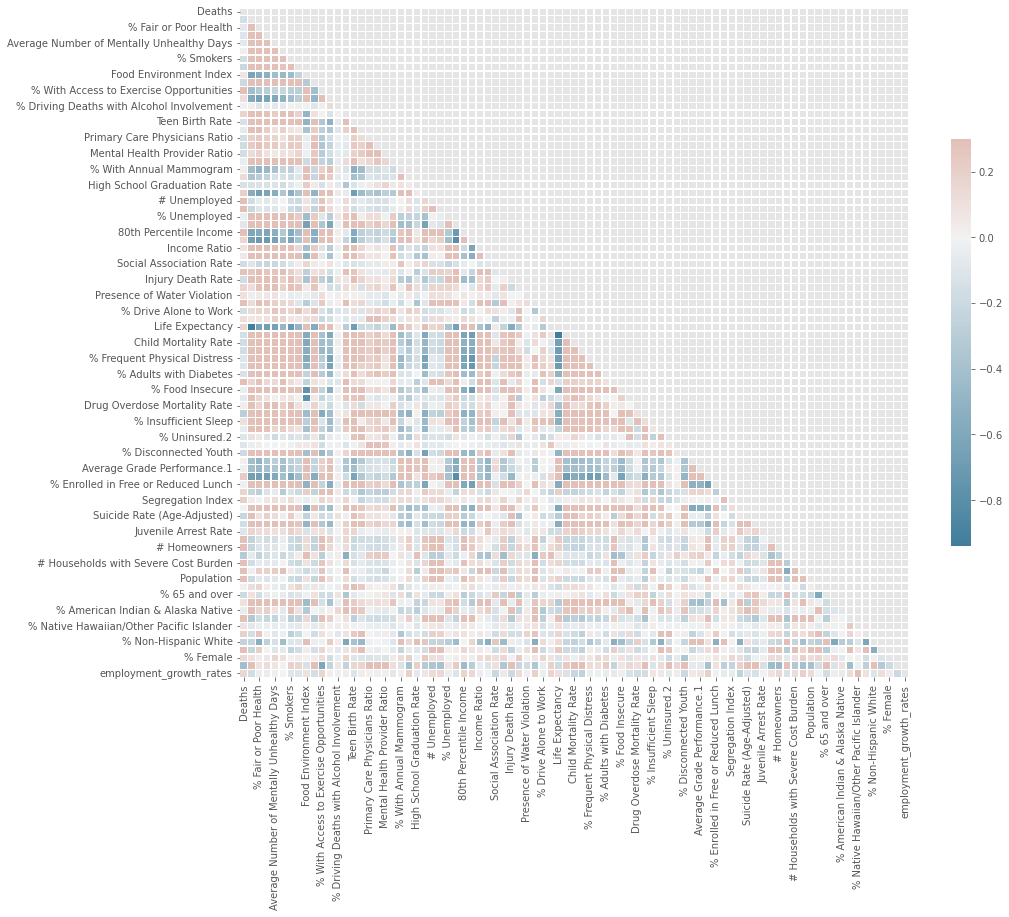

In [ ]:
# Lets Graph the Correlation

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
CorrT10 = corr['employment_growth_rates'].sort_values(ascending = False)[:10]

print(CorrT10)

employment_growth_rates                     1.000000
% Native Hawaiian/Other Pacific Islander    0.403801
Median Household Income                     0.205003
% Severe Housing Cost Burden                0.192857
% Severe Housing Problems                   0.192845
% Vaccinated                                0.189188
80th Percentile Income                      0.182849
% Long Commute - Drives Alone               0.179366
% With Access to Exercise Opportunities     0.167072
Deaths                                      0.158464
Name: employment_growth_rates, dtype: float64


In [ ]:
# Preparing for figures
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)

Text(0.5, 0, 'Median Household Income')

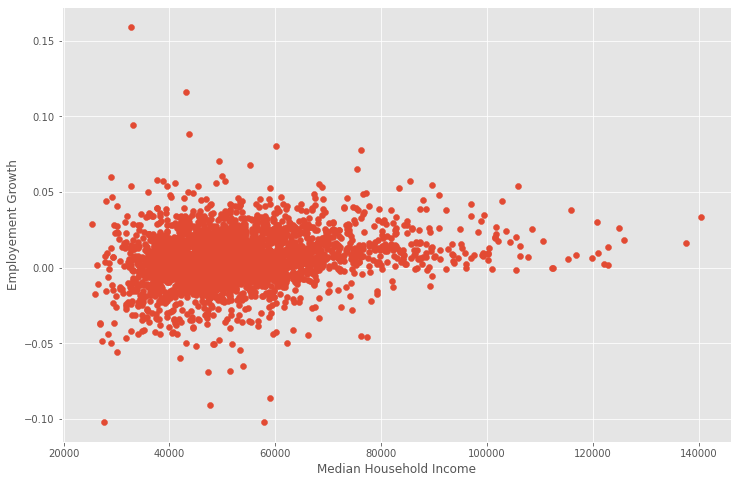

In [ ]:
# It looks like, there are increases in "Median Household Income" correspond to Employement Growth Rates. Let's see if there are outliers.
plt.scatter(x = Run_data['Median Household Income'], y = Run_data['employment_growth_rates'])
plt.ylabel('Employement Growth')
plt.xlabel('Median Household Income')

Text(0.5, 0, 'Infant Mortality Rate')

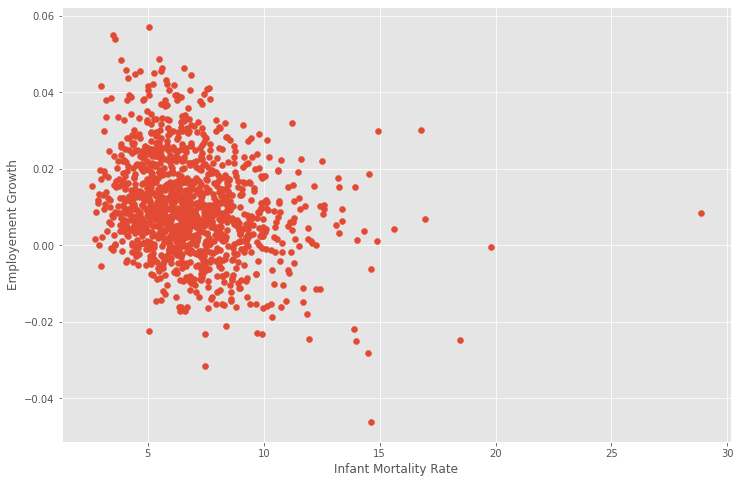

In [ ]:
# It looks like, there are increases in "Infant Mortality Rate" correspond to Employement Growth Rates. Let's see if there are outliers.
plt.scatter(x = Run_data['Infant Mortality Rate'], y = Run_data['employment_growth_rates'])
plt.ylabel('Employement Growth')
plt.xlabel('Infant Mortality Rate')

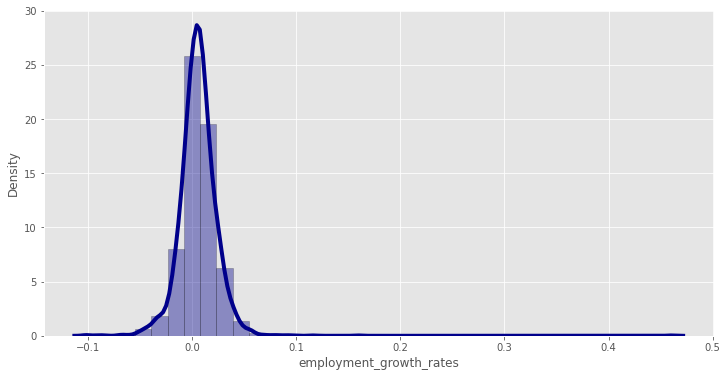

In [ ]:
# Density Plot and Histogram of Employement Growth Rates. I am looking for skewness in dependent variable

warnings.simplefilter(action='ignore', category=FutureWarning)
#
plt.figure(figsize=(12,6))
sns.distplot(Run_data['employment_growth_rates'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

In [ ]:
# check the missing values
print ('Total missing values in the train dataset', sum(Run_data.isna().sum()))

Total missing values in the train dataset 17263


In [ ]:
# Droping columns with percentage of missing values > 80% (Which happen to be no column)
Run_data_percentage = Run_data.isnull().sum() / Run_data.shape[0]
print (Run_data_percentage[Run_data_percentage > 0.80])
Run_data = Run_data.drop(Run_data_percentage[Run_data_percentage > 0.80].index, axis = 1)
Run_data.shape

Series([], dtype: float64)


(3141, 85)

In [ ]:
# Fill the missing values based on probability of occurrence
for column in Run_data.columns:
    null_vals = Run_data.isnull().values
    a, b = np.unique(Run_data.values[~null_vals], return_counts = 1)
    Run_data.loc[Run_data[column].isna(), column] = np.random.choice(a, Run_data[column].isnull().sum(), p = b / b.sum())

In [ ]:
# Normalizing the data
d = preprocessing.normalize(Run_data, axis = 0)
Run_data = pd.DataFrame(d, columns = Run_data.columns)
Run_data.head()

,Deaths,Years of Potential Life Lost Rate,% Fair or Poor Health,Average Number of Physically Unhealthy Days,Average Number of Mentally Unhealthy Days,% Low Birthweight,% Smokers,% Adults with Obesity,Food Environment Index,% Physically Inactive,...,% Black,% American Indian & Alaska Native,% Asian,% Native Hawaiian/Other Pacific Islander,% Hispanic,% Non-Hispanic White,% Not Proficient in English,% Female,% Rural,employment_growth_rates
0,0.001740,0.011606,0.020083,0.020887,0.019720,0.000047,0.018086,0.017840,0.000520,0.022147,...,0.020431,0.001061,0.006538,0.002034,0.003136,0.016862,0.004483,0.018383,0.000163,0.004421
1,0.006526,0.010500,0.016839,0.018601,0.018237,0.000045,0.017493,0.016608,0.000578,0.016913,...,0.009278,0.001707,0.006141,0.001222,0.004914,0.018859,0.002971,0.018415,0.000164,0.025405
2,0.001038,0.014640,0.028459,0.023910,0.021973,0.000062,0.022005,0.022340,0.000404,0.014998,...,0.050735,0.001456,0.002424,0.003373,0.004523,0.010357,0.008919,0.016871,0.000263,0.002295
3,0.001036,0.017102,0.018695,0.020216,0.019287,0.000056,0.019119,0.020143,0.000563,0.021381,...,0.022309,0.000967,0.001263,0.002117,0.002776,0.016926,0.001466,0.016715,0.000265,0.000196
4,0.002387,0.016185,0.020913,0.021402,0.020726,0.000041,0.019213,0.018108,0.000606,0.019338,...,0.001545,0.001444,0.001707,0.002208,0.010122,0.019716,0.009426,0.018124,0.000348,0.005196


In [ ]:
# Find Skewness and apply log transformation to reduce skewness over .75 by taking log(feature + 1)
from scipy.stats import skew
skewed_Run_data = Run_data.apply(lambda x: skew(x.dropna()))
skewed_Run_data = skewed_Run_data[skewed_Run_data > .95]
Run_data[skewed_Run_data.index] = np.log1p(Run_data[skewed_Run_data.index])
Run_data.shape

(3141, 85)

In [ ]:
# Saving Normalized and Unskew data

#Run_data.to_csv('NormEmpHealth.csv')


### Predictive Analysis

In [ ]:
# Predictive Analysis

# Separating trainnig and Testing data
X = Run_data.drop(['employment_growth_rates'], axis = 1)
y = Run_data['employment_growth_rates']

#for x in range(0,100):
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 65)

# Multiple linear Regression model

lr = linear_model.LinearRegression()
# Fitting the model
lr_regressor = lr.fit(X_train, y_train)

# make predictions based on model
y_pred = lr_regressor.predict(X_test)

mae = metrics.mean_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
r2 = metrics.r2_score(y_test, y_pred)
# Printing the metrics

  #print('For value:',x, ' R2 square:',r2, ', MAE:', mae, ', MSE:', mse)
print('R2 square:',r2)
print('MAE: ', mae)
print('MSE: ', mse)

R2 square: 0.26943372497602247
MAE:  0.00971393224484247
MSE:  0.00017969225125860156


In [ ]:
# Alternative Models

# XGBoost Regresssion

Rand_State = 0
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state = Rand_State)

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
                           
# Printing the metrics

mae = metrics.mean_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
r2 = metrics.r2_score(y_test, y_pred)

# Printing the metrics

print("XGBoost Regression")
print('R2 square:',r2)
print('MAE: ', mae)
print('MSE: ', mse)
# Random Forest Regressor

rf_regressor = RandomForestRegressor(n_estimators = 300 ,  random_state = Rand_State)
rf_regressor.fit(X_train,y_train)
#Predicting the Employement Growth Rates using test set 
y_pred = rf_regressor.predict(X_test)

# Printing the metrics

mae = metrics.mean_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
r2 = metrics.r2_score(y_test, y_pred)

# Printing the metrics

print("Random Forest Regression")
print('R2 square:',r2)
print('MAE: ', mae)
print('MSE: ', mse)

XGBoost Regression
R2 square: 0.3550429692826179
MAE:  0.009082539628894274
MSE:  0.00015863554721420138
Random Forest Regression
R2 square: 0.3753912488014003
MAE:  0.008818904273160271
MSE:  0.00015363062393622872
